In [1]:
!pip install sagemaker==1.72.0 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [422]:
%matplotlib inline
import os
import ast
import json
import numpy as np
import pandas as pd
import source
import math

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.estimator import SKLearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from IPython.display import Audio
sound_file = './sound/beep.wav'

import warnings
warnings.filterwarnings('ignore')

session = sagemaker.Session()
role = get_execution_role()

<h2> Data Processing </h2>

ROI is calculated using next price because we are trying to predict future ROI using the data from current time period.
Referred to https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v1c_xgboost.ipynb & https://towardsdatascience.com/cryptocurrency-price-prediction-using-lstms-tensorflow-for-hackers-part-iii-264fcdbccd3f

In [423]:
DATA_DIR = './data'

In [424]:
data = pd.read_csv(os.path.join(DATA_DIR, 'crypto-historical-data.csv'), 
                   parse_dates=['time'], 
                   index_col=0, 
                   keep_default_na=False,
                   header=0,
                   names=['market_cap', 'name', 'price', 'sym', 'time', 'volume'])

data.sort_values(by=['sym', 'time'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [425]:
data['rank'] = data.groupby("time")["market_cap"] \
                    .rank("dense", ascending=False) \
                    .astype(int)

data['market_share'] = data.groupby('time')["market_cap"] \
                    .apply(lambda x: x/float(x.sum()))

data['age'] = data.groupby(['sym'])["time"] \
                    .apply(lambda x: x - min(x)) \
                    .dt.days + 1

previous_price = data.groupby(['sym'])['price'].shift(-1)
data['roi'] = data['price']/previous_price - 1

In [426]:
data[data['sym'] == 'ETH'].head(10)

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
224231,167911000.0,Ethereum,0.753325,ETH,2015-08-08,674188.0,4,0.034732,1,0.073270
224232,42637600.0,Ethereum,0.701897,ETH,2015-08-09,532170.0,4,0.009641,2,-0.009247
224233,43130000.0,Ethereum,0.708448,ETH,2015-08-10,405283.0,4,0.009581,3,-0.337899
224234,42796500.0,Ethereum,1.070000,ETH,2015-08-11,1463100.0,4,0.009541,4,-0.122951
224235,64018400.0,Ethereum,1.220000,ETH,2015-08-12,2150620.0,4,0.013904,5,-0.333333
224236,73935400.0,Ethereum,1.830000,ETH,2015-08-13,4068680.0,4,0.016312,6,0.000000
224237,109594000.0,Ethereum,1.830000,ETH,2015-08-14,4637030.0,4,0.024201,7,0.082840
224238,109160000.0,Ethereum,1.690000,ETH,2015-08-15,2554360.0,4,0.023926,8,0.076433
224239,102028000.0,Ethereum,1.570000,ETH,2015-08-16,3550790.0,4,0.022676,9,0.308333
224240,95819700.0,Ethereum,1.200000,ETH,2015-08-17,1942830.0,4,0.021582,10,0.100917


<h2> Data Selection </h2>

In [503]:
VAL_START = pd.Timestamp('2016-04-25')
TEST_START = pd.Timestamp('2017-04-25')
END_TRAIN = TEST_START - pd.Timedelta(1, 'D')

In [504]:
# top_20_coins = data.query("time == @END_TRAIN") \
#                         .nlargest(20, 'market_cap') \
#                         .sym

In [505]:
filtered = data.query('volume > 100000 & sym != ""')
# filtered = filtered.query('sym == "ETH"')

In [506]:
filtered.sort_values(by=['sym', 'time'], inplace=True)
filtered.reset_index(drop=True, inplace=True)

<h2> Feature Engineering </h2>

In [510]:
feat = filtered.copy()

In [511]:
W = 7
TARGET = 'price'

In [512]:
# properties = ['market_cap', 'price', 'volume', 'rank', 'market_share', 'age', 'roi']
properties = ['market_cap', 'price', 'volume', 'age', 'roi']
feat_columns = []

for p in properties:
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        feat[col_name] = feat.groupby(['sym'])[p].shift(w)
        feat_columns.append(col_name)
    
    feat[p + '_mean'] = feat.groupby(['sym'])[p].shift(1) \
                                .transform(lambda x: x.rolling(w, min_periods=1).mean())
    feat[p + '_std'] = feat.groupby(['sym'])[p].shift(1) \
                                .transform(lambda x: x.rolling(w, min_periods=1).std())

feat.dropna(inplace=True)

In [513]:
feat.head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_lag_4,roi_lag_5,roi_lag_6,roi_lag_7,roi_mean,roi_std
8,134405000.0,PACcoin,0.000038,$PAC,2018-01-03,2851950.0,136,0.000200,43,-0.095238,...,2.160247,0.052632,-0.175000,-0.575758,-0.500000,0.857143,0.538462,-0.750000,-0.078932,0.599780
9,127389000.0,PACcoin,0.000042,$PAC,2018-01-04,2977860.0,144,0.000173,44,-0.807339,...,2.160247,-0.095238,0.052632,-0.175000,-0.575758,-0.500000,0.857143,0.538462,0.014606,0.523944
10,142047000.0,PACcoin,0.000218,$PAC,2018-01-05,49384200.0,141,0.000189,45,0.289941,...,2.160247,-0.807339,-0.095238,0.052632,-0.175000,-0.575758,-0.500000,0.857143,-0.177652,0.546128
11,535717000.0,PACcoin,0.000169,$PAC,2018-01-06,15334100.0,59,0.000688,46,-0.404930,...,2.160247,0.289941,-0.807339,-0.095238,0.052632,-0.175000,-0.575758,-0.500000,-0.258680,0.385447
12,440586000.0,PACcoin,0.000284,$PAC,2018-01-07,7416320.0,78,0.000543,47,0.868421,...,2.160247,-0.404930,0.289941,-0.807339,-0.095238,0.052632,-0.175000,-0.575758,-0.245099,0.377112


<h2> Data Split </h2>

In [514]:
train = feat.query("time < @VAL_START")
val = feat.query("time >= @VAL_START & time < @TEST_START")
trainval = feat.query("time <= @TEST_START")
test = feat.query("time >= @TEST_START")

In [515]:
cols_to_scale = feat_columns + [TARGET]

In [516]:
scaler_train = StandardScaler()
train_cols_scaled = scaler_train.fit_transform(train[cols_to_scale])
train_scaled = train.copy()
train_scaled[cols_to_scale] = train_cols_scaled

In [517]:
print(cols_to_scale)
print(scaler_train.var_)
print(scaler_train.mean_)

['market_cap_lag_1', 'market_cap_lag_2', 'market_cap_lag_3', 'market_cap_lag_4', 'market_cap_lag_5', 'market_cap_lag_6', 'market_cap_lag_7', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3', 'volume_lag_4', 'volume_lag_5', 'volume_lag_6', 'volume_lag_7', 'age_lag_1', 'age_lag_2', 'age_lag_3', 'age_lag_4', 'age_lag_5', 'age_lag_6', 'age_lag_7', 'roi_lag_1', 'roi_lag_2', 'roi_lag_3', 'roi_lag_4', 'roi_lag_5', 'roi_lag_6', 'roi_lag_7', 'price']
[3.78882581e+18 3.79387855e+18 3.79903615e+18 3.80389145e+18
 3.80851270e+18 3.81363495e+18 3.81957743e+18 2.13975507e+04
 2.14530618e+04 2.15063907e+04 2.15591446e+04 2.16107622e+04
 2.16584910e+04 2.17081707e+04 2.30028611e+14 2.29722697e+14
 2.29290446e+14 2.28625630e+14 2.27902479e+14 2.27652537e+14
 2.27594204e+14 8.73272118e+04 8.71569781e+04 8.70064445e+04
 8.68999851e+04 8.68928663e+04 8.69226233e+04 8.69841029e+04
 9.37234251e-03 9.535593

In [518]:
scaler_trainval = StandardScaler()
trainval_cols_scaled = scaler_trainval.fit_transform(trainval[cols_to_scale])
trainval_scaled = trainval.copy()
trainval_scaled[cols_to_scale] = trainval_cols_scaled

In [519]:
def scale_col(df, base, col):
    mean = df[base + '_mean']
    std = df[base + '_std']
    std = np.where(std == 0, 0.001, std)
    return (df[col] - mean)/std

In [520]:
val_scaled = val.copy()
for p in properties:
    val_scaled[p] = scale_col(val_scaled, p, p)
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        val_scaled[col_name] = scale_col(val_scaled, p, col_name)

In [521]:
test_scaled = test.copy()
for p in properties:
    test_scaled[p] = scale_col(test_scaled, p, p)
    
    for w in range(1, W+1):
        col_name = "{}_lag_{}".format(p, w)
        test_scaled[col_name] = scale_col(test_scaled, p, col_name)

In [522]:
test_scaled.describe()

,market_cap,price,volume,rank,market_share,age,roi,market_cap_lag_1,market_cap_lag_2,market_cap_lag_3,...,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_lag_4,roi_lag_5,roi_lag_6,roi_lag_7,roi_mean,roi_std
count,86732.000000,86732.000000,86732.000000,86732.000000,8.673200e+04,86732.000000,86732.000000,86732.000000,86732.000000,86732.000000,...,86732.000000,86732.000000,86732.000000,86732.000000,86732.000000,86732.000000,86732.000000,86732.000000,86732.000000,86732.000000
mean,0.129282,0.043981,0.705021,178.086254,4.009431e-03,1.928597,0.117160,-0.014201,-0.022621,-0.020884,...,3.861060,-0.008889,-0.004536,-0.001860,-0.002551,0.003749,0.007747,0.006341,0.011118,0.115101
std,5.912829,3.698762,27.369916,146.614933,3.322554e-02,3.976729,31.755246,1.111542,0.879366,0.783384,...,19.597784,0.918275,0.919991,0.924633,0.921686,0.930160,0.931476,0.934125,0.114326,0.270085
min,-45.725128,-25.405969,-20.106347,1.000000,2.028336e-08,0.385524,-198.027542,-2.264101,-2.261426,-2.261266,...,2.160247,-2.267787,-2.256111,-2.253098,-2.252453,-2.252705,-2.261044,-2.267787,-0.329434,0.000001
25%,-1.099262,-0.935010,-0.826509,64.000000,5.356126e-05,1.851640,-0.725585,-0.941670,-0.735303,-0.590942,...,2.160247,-0.663438,-0.666101,-0.675291,-0.676940,-0.680953,-0.678874,-0.661545,-0.015949,0.066813
50%,-0.110416,-0.067482,-0.369142,141.000000,1.463625e-04,1.851640,-0.040230,-0.094554,-0.078139,-0.065353,...,2.160247,-0.035887,-0.031508,-0.022444,-0.021449,-0.016820,-0.018913,-0.018900,0.008489,0.095739
75%,1.049641,0.795310,0.551193,256.000000,4.985606e-04,1.851640,0.678570,0.906789,0.678141,0.520782,...,2.160247,0.630646,0.632973,0.657570,0.655355,0.670694,0.676609,0.656145,0.034756,0.138544
max,1304.092715,942.087591,6333.953305,1220.000000,6.724049e-01,648.536987,9330.402310,2.267784,2.261938,2.259775,...,775.785930,2.267787,2.267787,2.267787,2.267787,2.267787,2.267787,2.267787,26.515529,69.545004


In [523]:
test_scaled.head()

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,age_std,roi_lag_1,roi_lag_2,roi_lag_3,roi_lag_4,roi_lag_5,roi_lag_6,roi_lag_7,roi_mean,roi_std
8,2.501047,PACcoin,1.454804,$PAC,2018-01-03,0.352230,136,0.000200,1.85164,-0.027187,...,2.160247,0.219353,-0.160173,-0.828347,-0.702038,1.560697,1.029366,-1.118858,-0.078932,0.599780
9,1.428188,PACcoin,1.387980,$PAC,2018-01-04,0.260343,144,0.000173,1.85164,-1.568766,...,2.160247,-0.209648,0.072576,-0.361882,-1.126768,-0.982177,1.608067,0.999832,0.014606,0.523944
10,1.396269,PACcoin,12.918870,$PAC,2018-01-05,23.286103,141,0.000189,1.85164,0.856196,...,2.160247,-1.153005,0.150905,0.421665,0.004855,-0.728962,-0.590244,1.894785,-0.177652,0.546128
11,8.923131,PACcoin,1.554277,$PAC,2018-01-06,0.324012,59,0.000688,1.85164,-0.379428,...,2.160247,1.423338,-1.423436,0.424033,0.807665,0.217100,-0.822622,-0.626077,-0.258680,0.385447
12,1.632396,PACcoin,2.562956,$PAC,2018-01-07,-0.251811,78,0.000543,1.85164,2.952761,...,2.160247,-0.423829,1.418784,-1.490913,0.397391,0.789503,0.185884,-0.876819,-0.245099,0.377112


In [524]:
train_X = train_scaled[feat_columns]
train_Y = train_scaled[[TARGET]]

trainval_X = trainval_scaled[feat_columns]
trainval_Y = trainval_scaled[[TARGET]]

val_X = val_scaled[feat_columns]
val_Y = val_scaled[[TARGET]]

test_X = test_scaled[feat_columns]
test_Y = test_scaled[[TARGET]]

<h2> Training </h2>

In [525]:
prefix = 'xgboost-new'

pd.concat([train_Y, train_X], axis=1).to_csv(os.path.join(DATA_DIR, 'train.csv'), header=False, index=False)
pd.concat([val_Y, val_X], axis=1).to_csv(os.path.join(DATA_DIR, 'val.csv'), header=False, index=False)

train_location = session.upload_data(os.path.join(DATA_DIR, 'train.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(DATA_DIR, 'val.csv'), key_prefix=prefix)

train_input = sagemaker.s3_input(s3_data=train_location, content_type='text/csv')
val_input = sagemaker.s3_input(s3_data=val_location, content_type='text/csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [526]:
container = get_image_uri(session.boto_region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# xgb.set_hyperparameters(max_depth=3,
#                         eta=0.1,
#                         gamma=0.1,
#                         min_child_weight=15,
#                         subsample=0.8,
#                         objective='reg:linear',
#                         early_stopping_rounds=10,
#                         num_round=200)
xgb.set_hyperparameters(max_depth=100,
                        eta=0.1,
                        gamma=0.2,
                        min_child_weight=5,
                        subsample=0.9,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

xgb.fit({'train': train_input, 'validation': val_input})

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-02-02 16:42:45 Starting - Starting the training job...
2021-02-02 16:42:48 Starting - Launching requested ML instances......
2021-02-02 16:43:51 Starting - Preparing the instances for training...
2021-02-02 16:44:38 Downloading - Downloading input data...
2021-02-02 16:45:16 Training - Training image download completed. Training in progress.
2021-02-02 16:45:16 Uploading - Uploading generated training model.Arguments: train
[2021-02-02:16:45:11:INFO] Running standalone xgboost training.
[2021-02-02:16:45:11:INFO] File size need to be processed in the node: 10.25mb. Available memory size in the node: 8446.64mb
[2021-02-02:16:45:11:INFO] Determined delimiter of CSV input is ','
[16:45:11] S3DistributionType set as FullyReplicated
[16:45:11] 6455x35 matrix with 225925 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-02-02:16:45:11:INFO] Determined delimiter of CSV input is ','
[16:45:11] S3DistributionType set as FullyReplicated
[16:45:11] 8750

In [527]:
predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

<h2> Predicting on Test Set </h2>

In [528]:
pred_Y = [predictor.predict(batch).decode('utf-8') for batch in np.array_split(test_X.values, 10)]
pred_Y = [ast.literal_eval(batch) for batch in pred_Y]
pred_Y = np.array([val for sublist in pred_Y for val in sublist])

In [529]:
pred_mean = test_scaled[TARGET+'_mean']
pred_std = test_scaled[TARGET+'_std']
# pred = (pred_Y * pred_std) + pred_mean
pred = pred_Y

In [530]:
test_result = test_scaled.copy()
test_result['pred'] = pred
test_result = test_result.set_index('time')

In [531]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [532]:
get_mape(test_result[TARGET], test_result['pred'])

71355772.89534491

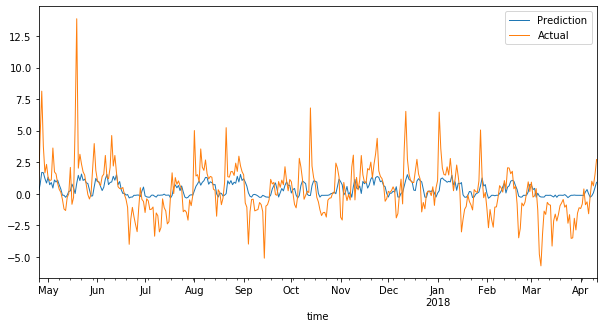

In [533]:
plt.figure(figsize=(10,5))

test_result[test_result['sym'] == 'ETH']['pred'].plot(label='Prediction', lw=1)
test_result[test_result['sym'] == 'ETH'][TARGET].plot(label='Actual', lw=1)

plt.legend()
plt.show()

<h2> Predicting on Train Set </h2>

In [534]:
pred_Y = [predictor.predict(batch).decode('utf-8') for batch in np.array_split(train_X.values, 10)]
pred_Y = [ast.literal_eval(batch) for batch in pred_Y]
pred_Y = np.array([val for sublist in pred_Y for val in sublist])

In [535]:
pred_mean = train[TARGET+'_mean']
pred_std = train[TARGET+'_std']
# pred = pred_Y * math.sqrt(scaler_train.var_[-1]) + scaler_train.mean_[-1]
# pred = pred_Y * pred_std + pred_mean
pred = pred_Y

In [536]:
train_result = train_scaled.copy()
train_result['pred'] = pred
train_result = train_result.set_index('time')

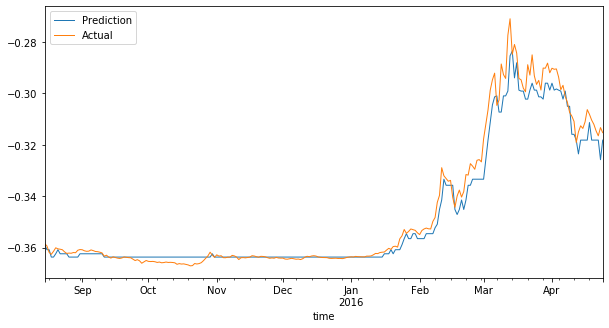

In [538]:
plt.figure(figsize=(10,5))

train_result[train_result['sym'] == 'ETH']['pred'].plot(label='Prediction', lw=1)
train_result[train_result['sym'] == 'ETH'][TARGET].plot(label='Actual', lw=1)

plt.legend()
plt.show()

In [502]:
predictor.delete_endpoint()

<h2> Trading </h2>

In [305]:
def update_mean(mean, t, new_value):
    if t == 0:
        return new_value
    else:
        return (mean * (t - 1) + new_value) / t

# Function to update standard deviation based on new value
def update_std(std, mean, new_mean, t, new_value):
    if t == 0:
        return 0
    else:
        return np.sqrt((std ** 2 * (t - 1) + (new_value - new_mean) * (new_value - mean)) / t)

In [306]:
# Function to execute the trading strategy over the trading horizon using asset matrix
def evaluate_strategy(result, target, n=10, initial_value=10000):
    total_value = initial_value
    mean_roi = 0
    std_roi = 0
    
    value_history = []
    roi_history = []
    
    t = 1

    dates = list(set(result.index))
    dates.sort()
    
    df = result.copy()
    if target == 'price':
        df['predicted_roi'] = (df['pred']/df['price_lag_1']) - 1
    else:
        df['predicted_roi'] = df['pred']
    df.sort_values(by='predicted_roi', ascending=False, inplace=True)

    for date in dates:
        temp_df = df.query('time == @date & predicted_roi > 0')

        if not temp_df.empty:
            top_n = temp_df.nlargest(n, 'predicted_roi')
            selected_n = len(top_n)
            day_return = sum(top_n['roi'] * total_value / selected_n)
            day_roi = day_return/total_value
        else:
            day_return = 0
            day_roi = 0
        
        total_value += day_return
        percent_returns = (total_value/initial_value - 1) * 100

        prev_mean_roi = mean_roi
        mean_roi = update_mean(prev_mean_roi, t, day_roi)
        std_roi = update_std(std_roi, prev_mean_roi, mean_roi, t, day_roi)
        sharpe_ratio = mean_roi/std_roi
        
        value_history.append(total_value)
        roi_history.append(day_roi)

        t += 1
        
    print('Cumulative Returns: {:.2e}%'.format(percent_returns))
    
    history = pd.concat([pd.DataFrame(dates), pd.DataFrame(value_history), pd.DataFrame(roi_history)], axis=1)
    history.columns = ['time', 'total_value', 'roi']
    history = history.set_index('time')
    return sharpe_ratio, percent_returns, history

In [307]:
result = evaluate_strategy(test_result, TARGET)

Cumulative Returns: 4.54e+01%
